In [13]:
# Ignore warnings to prevent
# UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
import warnings
warnings.filterwarnings("ignore")

from models.ml_basic_inference import predict_custom_input
from models.ml_sequential_inference import predict_custom_input_sequential
import matplotlib.pyplot as plt

female = 0
age = 70
height = 170
mass = 70
ta_set = 35
rh_set = 45

In [2]:
import jos3
import pandas as pd

def run_takahashi(female, age, height, mass, ta_set, rh_set, time_steps=540):
    # Scale units
    height = height / 100 # height from cm to m

    clo_females = 0.23
    clo_males = 0.15
    PAR = 1.2
    Va = 0.1

    # Get parameters
    sex = 'female' if female else 'male'
    clo = clo_females if female else clo_males
    # Build model (individual)
    model = jos3.JOS3(height=height, weight=mass, age=age, sex=sex)
    model.Icl = clo # Clothing level
    model.PAR = PAR  # Physical activity ratio [-]
    model.posture = 'sitting'  # Whether sitting or standing ??
    # Simulate 60 minutes in air-con before entering room
    model.Ta = 23
    model.RH = 9
    model.simulate(60)
    # Environmental parameters
    model.Ta = ta_set  # Operative temperature [oC]
    model.RH = rh_set  # Relative humidity [%]
    model.Va = Va  # Air velocity [m/s]
    model.simulate(time_steps)  # Exposure time = 540 [min]
    # Extract data
    df_results = pd.DataFrame(model.dict_results())  # Make pandas.DataFrame
    core_temp = df_results.TcrPelvis.tolist()
    skin_temp = df_results.TskMean.tolist()

    return core_temp[-1], skin_temp[-1]

In [3]:
from models.ji_two_node import two_nodes_optimized
from pythermalcomfort.utilities import body_surface_area
from pythermalcomfort.psychrometrics import p_sat_torr

def run_ji(female, age, height, mass, ta_set, rh_set, time_steps=540):
    # Scale units
    height = height / 100 # height from cm to m

    clo_females = 0.23
    clo_males = 0.15
    met = 1.3
    Va = 0.1

    # Get parameters
    clo = clo_females if female else clo_males

    # Calculate
    body_area = body_surface_area(mass, height)
    Ta = ta_set  # Operative temperature [oC]
    RH = rh_set  # Relative humidity [%]
    vapor_pressure = RH * p_sat_torr(Ta) / 100

    # Simulate cool environment
    cool_ta = 23
    cool_rh = 9
    cool_pressure = cool_rh * p_sat_torr(cool_ta) / 100
    initial_cooling = two_nodes_optimized(
        tdb=cool_ta,
        tr=cool_ta,
        v=Va,
        met=met,
        clo=clo,
        vapor_pressure=cool_pressure,
        wme=0,
        body_surface_area=body_area,
        p_atmospheric=101325,
        body_position="sitting",
        body_weight=mass,
        acclimatized=True,
        length_time_simulation=60
    )

    results = two_nodes_optimized(
        tdb=Ta,
        tr=Ta,
        v=Va,
        met=met,
        clo=clo,
        vapor_pressure=vapor_pressure,
        wme=0,
        body_surface_area=body_area,
        p_atmospheric=101325,
        body_position="sitting",
        body_weight=mass,
        acclimatized=True,
        length_time_simulation=time_steps,
        initial_skin_temp=initial_cooling['skin_temp_hist'][-1],
        initial_core_temp=initial_cooling['core_temp_hist'][-1],
    )

    # Extract data
    core_temp = results['core_temp_hist']
    skin_temp = results['skin_temp_hist']

    return core_temp[-1], skin_temp[-1]

In [11]:
def sensitivity_analysis(variable, values, split_subplots=False, connect_dots=False):
    models = ['Ridge Regression', 'GRU', 'Takahashi', 'Ji']
    model_functions = [
        (predict_custom_input,),
        (predict_custom_input_sequential,),
        (run_takahashi,),
        (run_ji,),
    ]
    results = {model: [] for model in models}

    for value in values:
        for model, functions in zip(models, model_functions):
            if variable == 'female':
                args = (value, age, height, mass, ta_set, rh_set)
            elif variable == 'age':
                args = (female, value, height, mass, ta_set, rh_set)
            elif variable == 'height':
                args = (female, age, value, mass, ta_set, rh_set)
            elif variable == 'mass':
                args = (female, age, height, value, ta_set, rh_set)
            elif variable == 'ta_set':
                args = (female, age, height, mass, value, rh_set)
            elif variable == 'rh_set':
                args = (female, age, height, mass, ta_set, value)

            model_results = [func(*args) for func in functions]
            results[model].append(model_results)

    if split_subplots:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
    else:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax1 = ax2 = ax

    colors = ['b', 'r', 'g', 'y']
    markers = ['o', 'x']

    for i, value in enumerate(values):
        for model, color in zip(models, colors):
            for j, (tre, mtsk) in enumerate(results[model][i]):
                label = f'{model} ({"Core" if j == 0 else "Skin"})' if i == 0 else None
                ax1.plot(value, tre, color + markers[0], label=label)
                ax2.plot(value, mtsk, color + markers[1])

                if connect_dots:
                    if i > 0:
                        prev_tre, prev_mtsk = results[model][i - 1][j]
                        ax1.plot([values[i - 1], value], [prev_tre, tre], color)
                        ax2.plot([values[i - 1], value], [prev_mtsk, mtsk], color)

    ax1.set_xlabel(variable)
    ax1.set_ylabel('Final Core Temperature (°C)')
    ax1.legend()

    ax2.set_xlabel(variable)
    ax2.set_ylabel('Final Skin Temperature (°C)')

    plt.tight_layout()
    plt.savefig(f'figures/sensitivity_{variable}.pdf')
    plt.show()

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00


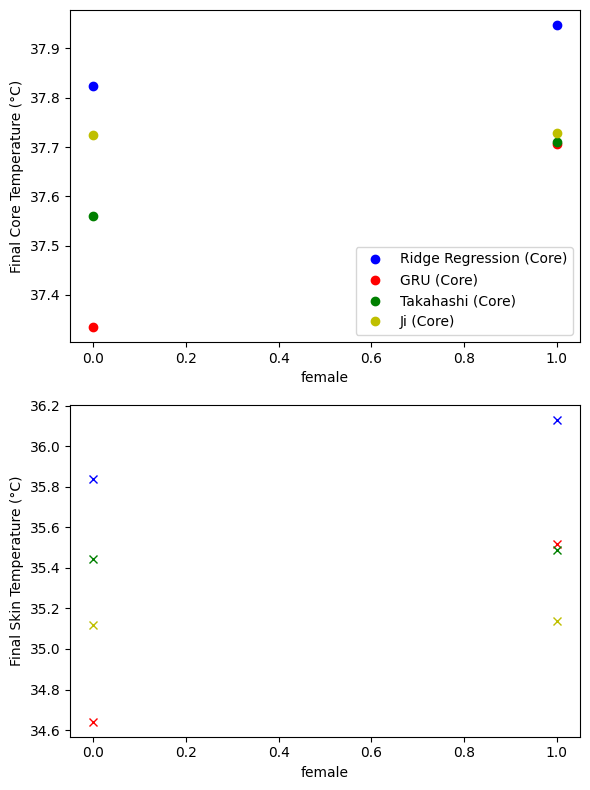

In [14]:
sensitivity_analysis('female', [0, 1], split_subplots=True)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00


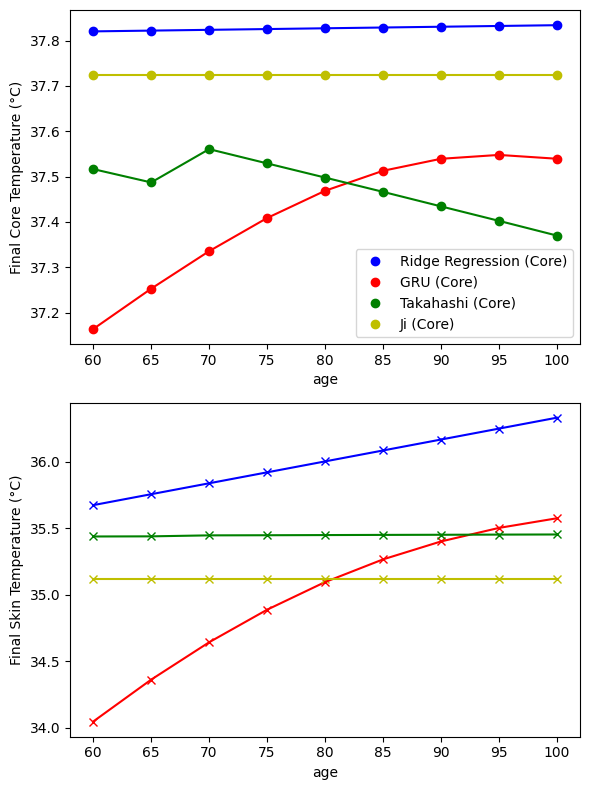

In [15]:
sensitivity_analysis('age', [60, 65, 70, 75, 80, 85, 90, 95, 100], split_subplots=True, connect_dots=True)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00


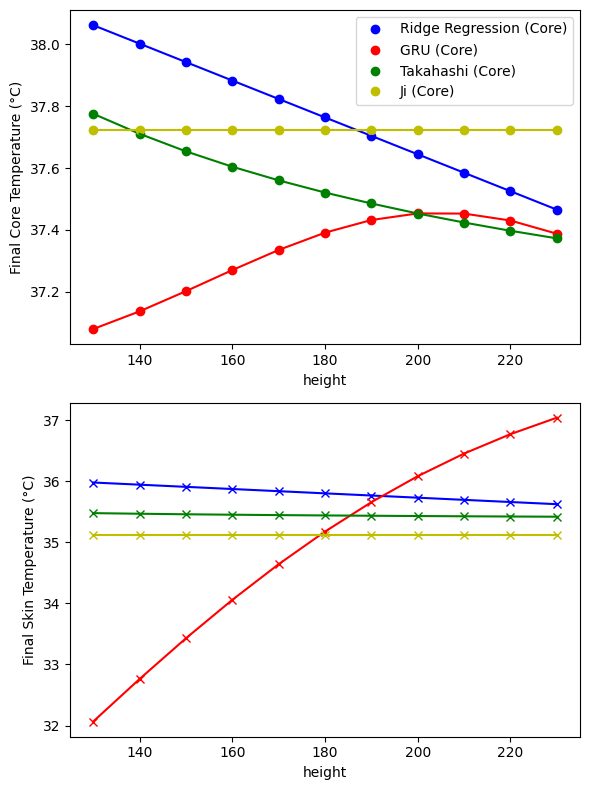

In [16]:
sensitivity_analysis('height', [130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230], split_subplots=True, connect_dots=True)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00


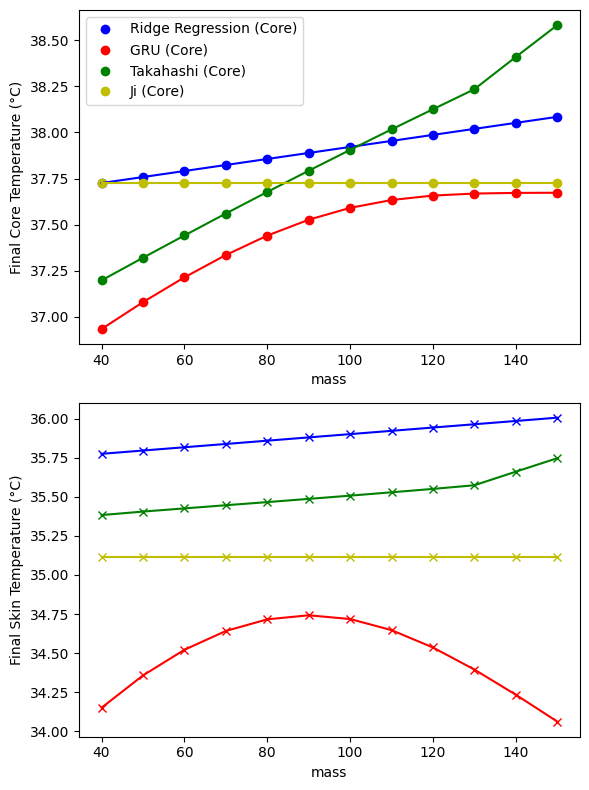

In [17]:
sensitivity_analysis('mass', [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], split_subplots=True, connect_dots=True)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
S

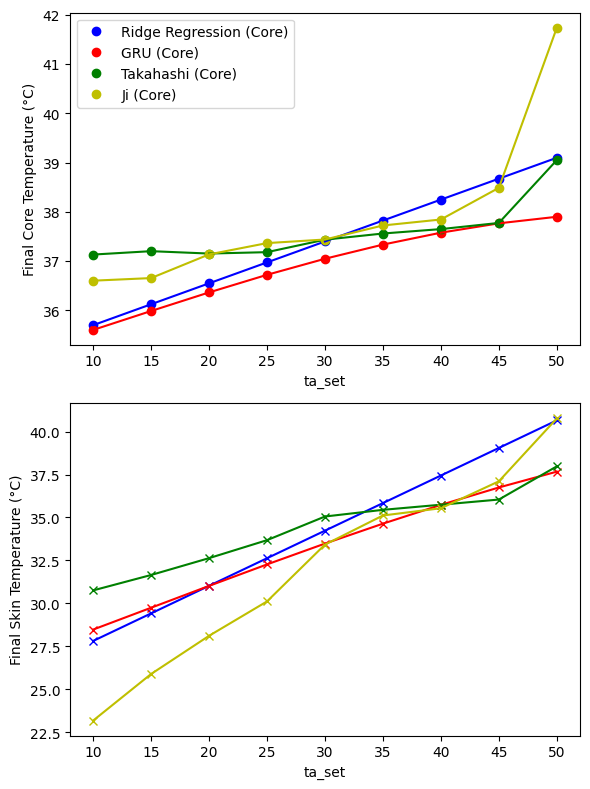

In [18]:
sensitivity_analysis('ta_set', [10, 15, 20, 25, 30, 35, 40, 45, 50], split_subplots=True, connect_dots=True)

Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
Skin wetness exceeds max value $1.00
S

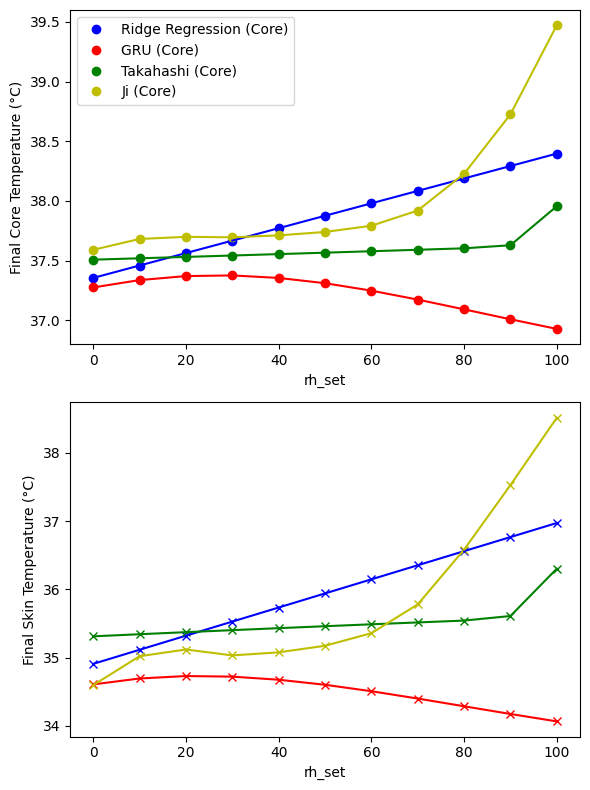

In [19]:
sensitivity_analysis('rh_set', [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], split_subplots=True, connect_dots=True)